#                                            Car Damage Detection Project

In [25]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
import matplotlib.pyplot as plt

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [32]:
image_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
]) 

The values mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225] are taken from the ImageNet channel-wise mean and standard deviation, and they’re used because many pretrained vision models were trained with them. These are the empirical statistics of the ImageNet training dataset. For each channel (R, G, B), it applies:

output = (input − mean) / std
So every pixel is standardized per channel.

In [41]:
dataset = datasets.ImageFolder(root="dataset",
    transform=image_transform )

In [42]:
len(dataset)

2300

In [43]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [44]:
num_classes = len(dataset.classes)
num_classes

6

In [45]:
# Deciding train and validation dataset size

train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size
train_size,val_size

(1725, 575)

In [46]:
# Splitting the dataset

train_dataset , val_dataset = random_split(dataset,[train_size,val_size])


In [47]:
train_loader = DataLoader(train_dataset, batch_size=32,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=32,shuffle=False)

In [53]:
X_batch,y_batch=next(iter(train_loader))
X_batch.shape,y_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [54]:
for images,labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


images is a batch of tensors from the DataLoader

Shape of images is typically [batch_size, channels, height, width] → e.g., [32, 3, 224, 224]

images[1] selects the second image in the batch (indexing starts at 0)
PyTorch images are channels-first (C, H, W)

Libraries like Matplotlib expect channels-last (H, W, C)

So we do this permutation before plotting:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8610327..2.2216995].


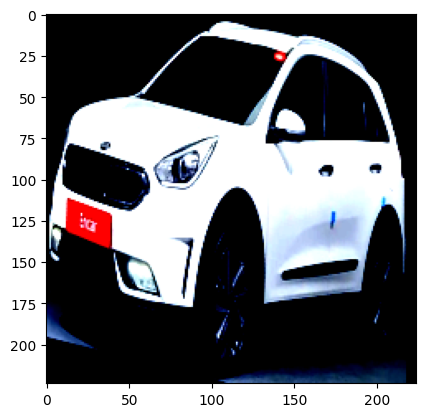

In [57]:
plt.imshow(images[0].permute(1,2,0))

### Model 1 : Convolutional Neural Network

In [75]:
class CarCNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(3),stride=1,padding=1), # output=>[16,224,224]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # output=> [16,112,112] Maxpool is used for downsampling so padding is zero here.
            
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3),stride=1,padding=1), # output=>[32,112,112]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # output=> [32,56,56]

            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3),stride=1,padding=1), # output=>[64,56,56]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # output=> [64,28,28]

            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Linear(512,num_classes)
        )

    def forward(self,x):
            x=self.network(x)
            return x
            
    

In [76]:
len(train_loader.dataset) # length of training data

1725

In [79]:
# Training the training_model

def train_model(model,criterion,optimizer,num_epochs):
    start = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for batch_num,(images,labels) in enumerate(train_loader):
             # Move data to device
            images,labels = images.to(device), labels.to(device)

             # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)

            loss = criterion(outputs,labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss +=loss.item()

            # Print batch-wise loss every 10 batches

            if (batch_num + 1)%10 == 0:
                print(f"Batch_No: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")

            # Update running loss
            running_loss +=loss.item() * images.size(0) # loss per batch is multiplied by size of batch.

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for images,labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                # calculate number of correct predictions
                _, predicted = torch.max(outputs.data,1)
                total+=labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
        
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")

    end = time.time()

    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions
                

In [80]:
# Instantiate the training_model, loss function, and optimizer
model = CarCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, 10)

Batch_No: 10, Epoch: 1, Loss: 1.79
Batch_No: 20, Epoch: 1, Loss: 1.81
Batch_No: 30, Epoch: 1, Loss: 1.53
Batch_No: 40, Epoch: 1, Loss: 1.48
Batch_No: 50, Epoch: 1, Loss: 1.79
Epoch [1/10], Avg Loss: 1.9971
*** Validation Accuracy: 42.09% ***
Batch_No: 10, Epoch: 2, Loss: 1.33
Batch_No: 20, Epoch: 2, Loss: 1.29
Batch_No: 30, Epoch: 2, Loss: 1.29
Batch_No: 40, Epoch: 2, Loss: 1.06
Batch_No: 50, Epoch: 2, Loss: 1.15
Epoch [2/10], Avg Loss: 1.2940
*** Validation Accuracy: 46.26% ***
Batch_No: 10, Epoch: 3, Loss: 0.94
Batch_No: 20, Epoch: 3, Loss: 1.04
Batch_No: 30, Epoch: 3, Loss: 1.12
Batch_No: 40, Epoch: 3, Loss: 1.25
Batch_No: 50, Epoch: 3, Loss: 0.97
Epoch [3/10], Avg Loss: 1.1406
*** Validation Accuracy: 49.04% ***
Batch_No: 10, Epoch: 4, Loss: 1.41
Batch_No: 20, Epoch: 4, Loss: 0.94
Batch_No: 30, Epoch: 4, Loss: 1.10
Batch_No: 40, Epoch: 4, Loss: 1.03
Batch_No: 50, Epoch: 4, Loss: 0.84
Epoch [4/10], Avg Loss: 1.0637
*** Validation Accuracy: 48.52% ***
Batch_No: 10, Epoch: 5, Loss: 0.

### Model 2: CNN with Regularization

In [88]:
class CarCNNwithRegularization(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels=16,kernel_size = 3,stride=1,padding = 1), # output=>[16,224,224]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # output=>[16,112,112]

            nn.Conv2d(in_channels = 16, out_channels=32,kernel_size = 3,stride=1,padding = 1), # output=>[32,112,112]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # output=>[32,56,56]

            nn.Conv2d(in_channels = 32, out_channels=64,kernel_size = 3,stride=1,padding = 1), # output=>[64,56,56]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # output=>[64,28,28]

            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)

            
        )

    def forward(self,x):
        x=self.network(x)
        return x
    
    

In [89]:
model = CarCNNwithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4) #L2 Regularization

all_labels, all_predictions = train_model(model,criterion,optimizer,10)

Batch_No: 10, Epoch: 1, Loss: 16.24
Batch_No: 20, Epoch: 1, Loss: 6.98
Batch_No: 30, Epoch: 1, Loss: 1.70
Batch_No: 40, Epoch: 1, Loss: 1.56
Batch_No: 50, Epoch: 1, Loss: 1.67
Epoch [1/10], Avg Loss: 9.0975
*** Validation Accuracy: 38.61% ***
Batch_No: 10, Epoch: 2, Loss: 1.31
Batch_No: 20, Epoch: 2, Loss: 1.26
Batch_No: 30, Epoch: 2, Loss: 1.25
Batch_No: 40, Epoch: 2, Loss: 1.24
Batch_No: 50, Epoch: 2, Loss: 1.24
Epoch [2/10], Avg Loss: 1.3917
*** Validation Accuracy: 50.09% ***
Batch_No: 10, Epoch: 3, Loss: 1.33
Batch_No: 20, Epoch: 3, Loss: 1.20
Batch_No: 30, Epoch: 3, Loss: 1.07
Batch_No: 40, Epoch: 3, Loss: 1.16
Batch_No: 50, Epoch: 3, Loss: 1.14
Epoch [3/10], Avg Loss: 1.3207
*** Validation Accuracy: 49.91% ***
Batch_No: 10, Epoch: 4, Loss: 1.48
Batch_No: 20, Epoch: 4, Loss: 1.53
Batch_No: 30, Epoch: 4, Loss: 1.40
Batch_No: 40, Epoch: 4, Loss: 1.30
Batch_No: 50, Epoch: 4, Loss: 0.99
Epoch [4/10], Avg Loss: 1.2655
*** Validation Accuracy: 48.35% ***
Batch_No: 10, Epoch: 5, Loss: 1

After the 8th epoch, the validation accuracy reached 54.26%, but it began to decline in subsequent epochs, dropping to 52.52% in the 9th epoch and further to 48.70% in the 10th epoch. This degradation in performance suggests that the model may be overfitting, likely due to insufficient training data. To address this issue and improve generalization, we therefore explore the use of pre-trained models.

#### Model 3: ResNet18

In [90]:
from torchvision.models import resnet18

model = resnet18(pretrained=True)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

C:\Users\Ashok\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ashok\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Ashok/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:15<00:00, 3.05MB/s]


In [92]:
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [94]:
all_labels, all_predictions = train_model(model,criterion,optimizer,10)

Batch_No: 10, Epoch: 1, Loss: 0.72
Batch_No: 20, Epoch: 1, Loss: 0.70
Batch_No: 30, Epoch: 1, Loss: 0.75
Batch_No: 40, Epoch: 1, Loss: 0.97
Batch_No: 50, Epoch: 1, Loss: 0.88
Epoch [1/10], Avg Loss: 0.8377
*** Validation Accuracy: 62.61% ***
Batch_No: 10, Epoch: 2, Loss: 0.92
Batch_No: 20, Epoch: 2, Loss: 0.73
Batch_No: 30, Epoch: 2, Loss: 1.01
Batch_No: 40, Epoch: 2, Loss: 0.62
Batch_No: 50, Epoch: 2, Loss: 0.70
Epoch [2/10], Avg Loss: 0.7991
*** Validation Accuracy: 63.83% ***
Batch_No: 10, Epoch: 3, Loss: 0.62
Batch_No: 20, Epoch: 3, Loss: 0.90
Batch_No: 30, Epoch: 3, Loss: 0.80
Batch_No: 40, Epoch: 3, Loss: 0.79
Batch_No: 50, Epoch: 3, Loss: 0.91
Epoch [3/10], Avg Loss: 0.7708
*** Validation Accuracy: 64.52% ***
Batch_No: 10, Epoch: 4, Loss: 0.89
Batch_No: 20, Epoch: 4, Loss: 0.85
Batch_No: 30, Epoch: 4, Loss: 0.82
Batch_No: 40, Epoch: 4, Loss: 0.55
Batch_No: 50, Epoch: 4, Loss: 0.58
Epoch [4/10], Avg Loss: 0.7601
*** Validation Accuracy: 65.22% ***
Batch_No: 10, Epoch: 5, Loss: 0.

It can be observed that Accuracy jumped from ~50% → ~65%. 
This confirms that transfer learning with ResNet18 is much better than training a CNN from scratch

### Model 4: Transfer Learning with EfficientNet

In [95]:
model = models.efficientnet_b0(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Ashok/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|█████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:06<00:00, 3.42MB/s]


In [96]:
model.classifier[1].in_features

1280

In [97]:
class CarEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x        

In [100]:
model = CarEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001) # only trains new classifier parameters

all_labels, all_predictions = train_model(model, criterion, optimizer, 10)

Batch_No: 10, Epoch: 1, Loss: 1.68
Batch_No: 20, Epoch: 1, Loss: 1.52
Batch_No: 30, Epoch: 1, Loss: 1.40
Batch_No: 40, Epoch: 1, Loss: 1.18
Batch_No: 50, Epoch: 1, Loss: 1.12
Epoch [1/10], Avg Loss: 1.4984
*** Validation Accuracy: 57.91% ***
Batch_No: 10, Epoch: 2, Loss: 1.28
Batch_No: 20, Epoch: 2, Loss: 1.17
Batch_No: 30, Epoch: 2, Loss: 0.98
Batch_No: 40, Epoch: 2, Loss: 1.06
Batch_No: 50, Epoch: 2, Loss: 0.91
Epoch [2/10], Avg Loss: 1.1534
*** Validation Accuracy: 59.65% ***
Batch_No: 10, Epoch: 3, Loss: 1.02
Batch_No: 20, Epoch: 3, Loss: 0.96
Batch_No: 30, Epoch: 3, Loss: 1.07
Batch_No: 40, Epoch: 3, Loss: 1.01
Batch_No: 50, Epoch: 3, Loss: 1.03
Epoch [3/10], Avg Loss: 1.0256
*** Validation Accuracy: 62.96% ***
Batch_No: 10, Epoch: 4, Loss: 0.92
Batch_No: 20, Epoch: 4, Loss: 1.00
Batch_No: 30, Epoch: 4, Loss: 1.12
Batch_No: 40, Epoch: 4, Loss: 0.90
Batch_No: 50, Epoch: 4, Loss: 1.13
Epoch [4/10], Avg Loss: 0.9630
*** Validation Accuracy: 64.87% ***
Batch_No: 10, Epoch: 5, Loss: 0.

### Model 5 : Transfer Learning with pre-trained ResNet-50

In [101]:

class CarResNet(nn.Module):
    def __init__(self,num_classes,dropout_rate=0.50):
        super().__init__()

        # Load pre-trained ResNet-50
        self.model = models.resnet50(weights="DEFAULT")

        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze layer4(last convolutional block) and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        # Replace the final fully connected layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    def forward(self,x):
        return self.model(x)
        
        
        

In [ ]:
model = CarResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)



In [104]:
labels, predictions = train_model(model, criterion, optimizer, 10)

Batch_No: 10, Epoch: 1, Loss: 1.02
Batch_No: 20, Epoch: 1, Loss: 0.71
Batch_No: 30, Epoch: 1, Loss: 0.61
Batch_No: 40, Epoch: 1, Loss: 1.17
Batch_No: 50, Epoch: 1, Loss: 0.64
Epoch [1/10], Avg Loss: 0.8987
*** Validation Accuracy: 66.96% ***
Batch_No: 10, Epoch: 2, Loss: 0.53
Batch_No: 20, Epoch: 2, Loss: 0.46
Batch_No: 30, Epoch: 2, Loss: 0.46
Batch_No: 40, Epoch: 2, Loss: 0.46
Batch_No: 50, Epoch: 2, Loss: 0.41
Epoch [2/10], Avg Loss: 0.4911
*** Validation Accuracy: 77.04% ***
Batch_No: 10, Epoch: 3, Loss: 0.24
Batch_No: 20, Epoch: 3, Loss: 0.32
Batch_No: 30, Epoch: 3, Loss: 0.22
Batch_No: 40, Epoch: 3, Loss: 0.47
Batch_No: 50, Epoch: 3, Loss: 0.72
Epoch [3/10], Avg Loss: 0.3469
*** Validation Accuracy: 72.87% ***
Batch_No: 10, Epoch: 4, Loss: 0.23
Batch_No: 20, Epoch: 4, Loss: 0.25
Batch_No: 30, Epoch: 4, Loss: 0.06
Batch_No: 40, Epoch: 4, Loss: 0.28
Batch_No: 50, Epoch: 4, Loss: 0.69
Epoch [4/10], Avg Loss: 0.2864
*** Validation Accuracy: 74.61% ***
Batch_No: 10, Epoch: 5, Loss: 0.

We got approx. 82% validation accuracy with ResNet-50 which is a good improvement in our model. Lets try hyperparameter-tuning to increase the accuracy.

### Hyperparameter Tuning of ResNet-50

In [105]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest values for the hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    
    # Load the training_model
    model = CarResNet(num_classes=num_classes, dropout_rate=dropout_rate).to(device)
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    # Training loop (using fewer epochs for faster hyperparameter tuning)
    epochs = 3
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        
        # Report intermediate result to Optuna
        trial.report(accuracy, epoch)
        
        # Handle pruning (if applicable)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    end = time.time()
    print(f"Execution time: {end - start} seconds")
    
    return accuracy

In [107]:
import optuna

C:\Users\Ashok\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [108]:
# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2026-01-27 16:16:53,967] A new study created in memory with name: no-name-b7eadb86-fc11-4d2c-bb3d-5c3a329bfeba
[I 2026-01-27 16:25:15,817] Trial 0 finished with value: 77.56521739130434 and parameters: {'lr': 0.0003308284149619167, 'dropout_rate': 0.2138149429807628}. Best is trial 0 with value: 77.56521739130434.


Execution time: 492.5116684436798 seconds


[I 2026-01-27 16:32:49,383] Trial 1 finished with value: 73.73913043478261 and parameters: {'lr': 5.765970226577499e-05, 'dropout_rate': 0.2049511487764463}. Best is trial 0 with value: 77.56521739130434.


Execution time: 453.2015767097473 seconds


[I 2026-01-27 16:40:30,400] Trial 2 finished with value: 60.17391304347826 and parameters: {'lr': 2.179482820812506e-05, 'dropout_rate': 0.36577205836022253}. Best is trial 0 with value: 77.56521739130434.


Execution time: 460.2583317756653 seconds


[I 2026-01-27 16:48:13,533] Trial 3 finished with value: 72.34782608695652 and parameters: {'lr': 5.627869415487629e-05, 'dropout_rate': 0.4551743296175069}. Best is trial 0 with value: 77.56521739130434.


Execution time: 462.44953656196594 seconds


[I 2026-01-27 16:56:07,839] Trial 4 finished with value: 50.95652173913044 and parameters: {'lr': 1.1683057438666868e-05, 'dropout_rate': 0.20663238394709693}. Best is trial 0 with value: 77.56521739130434.


Execution time: 473.5758776664734 seconds


[I 2026-01-27 17:03:51,999] Trial 5 finished with value: 74.6086956521739 and parameters: {'lr': 0.0006218627840745583, 'dropout_rate': 0.28747747320339606}. Best is trial 0 with value: 77.56521739130434.


Execution time: 463.45846033096313 seconds


[I 2026-01-27 17:06:25,381] Trial 6 pruned. 
[I 2026-01-27 17:09:01,995] Trial 7 pruned. 
[I 2026-01-27 17:16:49,086] Trial 8 finished with value: 78.26086956521739 and parameters: {'lr': 0.0006757603945159306, 'dropout_rate': 0.4649534429777921}. Best is trial 8 with value: 78.26086956521739.


Execution time: 466.3979597091675 seconds


[I 2026-01-27 17:19:25,554] Trial 9 pruned. 
[I 2026-01-27 17:26:54,038] Trial 10 finished with value: 76.0 and parameters: {'lr': 0.0002722883128956631, 'dropout_rate': 0.38781288673176917}. Best is trial 8 with value: 78.26086956521739.


Execution time: 447.751238822937 seconds


[I 2026-01-27 17:31:39,719] Trial 11 finished with value: 75.47826086956522 and parameters: {'lr': 0.0009714335860352676, 'dropout_rate': 0.4994404649167444}. Best is trial 8 with value: 78.26086956521739.


Execution time: 284.837482213974 seconds


[I 2026-01-27 17:35:54,125] Trial 12 finished with value: 77.21739130434783 and parameters: {'lr': 0.00025069454262158366, 'dropout_rate': 0.307524000800807}. Best is trial 8 with value: 78.26086956521739.


Execution time: 253.93615007400513 seconds


[I 2026-01-27 17:40:11,950] Trial 13 finished with value: 74.43478260869566 and parameters: {'lr': 0.00028893170240067146, 'dropout_rate': 0.39779954346542784}. Best is trial 8 with value: 78.26086956521739.


Execution time: 257.3328790664673 seconds


[I 2026-01-27 17:43:01,560] Trial 14 pruned. 
[I 2026-01-27 17:44:27,693] Trial 15 pruned. 
[I 2026-01-27 17:45:52,420] Trial 16 pruned. 
[I 2026-01-27 17:50:01,977] Trial 17 finished with value: 74.26086956521739 and parameters: {'lr': 0.0004772779863961125, 'dropout_rate': 0.34497258795979013}. Best is trial 8 with value: 78.26086956521739.


Execution time: 249.1140627861023 seconds


[I 2026-01-27 17:51:26,009] Trial 18 pruned. 
[I 2026-01-27 17:55:36,789] Trial 19 finished with value: 77.21739130434783 and parameters: {'lr': 0.0003903463970472561, 'dropout_rate': 0.41498365749605226}. Best is trial 8 with value: 78.26086956521739.


Execution time: 250.33085298538208 seconds


In [110]:
study.best_params

{'lr': 0.0006757603945159306, 'dropout_rate': 0.4649534429777921}

Although Optuna suggested slightly different hyperparameter values, the manually tuned configuration achieved higher validation accuracy of approx. 82%. This discrepancy can be attributed to the limited number of training epochs used during hyperparameter optimization and inherent stochasticity in deep learning training. Therefore, the manually selected hyperparameters lr = 0.001, dropout = 0.5 were retained as they demonstrated superior performance during full training.

Based on experimental results, the configuration with learning rate 0.001 and dropout 0.5 consistently achieved the highest validation accuracy during full training. Although automated hyperparameter tuning suggested slightly different values, these were optimized over fewer epochs. Therefore, the manually selected hyperparameters were retained for final training. 

#### Let's train the model with hyperparameters lr = 0.001, dropout = 0.5

In [111]:
model = CarResNet(num_classes=num_classes,dropout_rate=0.5).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [112]:
labels, predictions = train_model(model, criterion, optimizer, 10)

Batch_No: 10, Epoch: 1, Loss: 0.94
Batch_No: 20, Epoch: 1, Loss: 0.78
Batch_No: 30, Epoch: 1, Loss: 1.27
Batch_No: 40, Epoch: 1, Loss: 0.70
Batch_No: 50, Epoch: 1, Loss: 0.68
Epoch [1/10], Avg Loss: 0.9354
*** Validation Accuracy: 66.61% ***
Batch_No: 10, Epoch: 2, Loss: 0.28
Batch_No: 20, Epoch: 2, Loss: 0.33
Batch_No: 30, Epoch: 2, Loss: 0.38
Batch_No: 40, Epoch: 2, Loss: 0.21
Batch_No: 50, Epoch: 2, Loss: 0.57
Epoch [2/10], Avg Loss: 0.4654
*** Validation Accuracy: 72.87% ***
Batch_No: 10, Epoch: 3, Loss: 0.16
Batch_No: 20, Epoch: 3, Loss: 0.31
Batch_No: 30, Epoch: 3, Loss: 0.47
Batch_No: 40, Epoch: 3, Loss: 0.44
Batch_No: 50, Epoch: 3, Loss: 0.26
Epoch [3/10], Avg Loss: 0.3631
*** Validation Accuracy: 74.26% ***
Batch_No: 10, Epoch: 4, Loss: 0.14
Batch_No: 20, Epoch: 4, Loss: 0.25
Batch_No: 30, Epoch: 4, Loss: 0.29
Batch_No: 40, Epoch: 4, Loss: 0.37
Batch_No: 50, Epoch: 4, Loss: 0.30
Epoch [4/10], Avg Loss: 0.2765
*** Validation Accuracy: 77.04% ***
Batch_No: 10, Epoch: 5, Loss: 0.

The model achieved a validation accuracy of 82.26% in one run. Subsequent repeated training with the same configuration showed minor variations (e.g., 78–80%) due to the stochastic nature of training (weight initialization, dropout, and data shuffling). Given the minimal variability and the diminishing returns of additional training, we retained this configuration as the final model. This decision ensures reproducibility and reflects realistic performance on the dataset.

Overall, the ResNet-50 transfer learning model with the selected hyperparameters achieved robust and stable performance for the car damage detection task.

### Model Evaluation

In [113]:
# Classification Report

from sklearn.metrics import classification_report , confusion_matrix
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       131
           1       0.68      0.69      0.69        95
           2       0.82      0.86      0.84       115
           3       0.86      0.78      0.82        86
           4       0.71      0.68      0.69        71
           5       0.74      0.82      0.78        77

    accuracy                           0.78       575
   macro avg       0.78      0.77      0.77       575
weighted avg       0.78      0.78      0.78       575



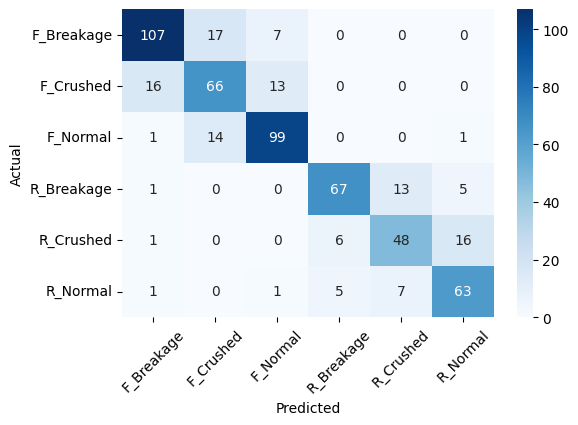

In [121]:
# Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_names = dataset.classes
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Save the Model

In [122]:
torch.save(model.state_dict(), "car_damage_resnet50.pth")